# Week 1 - Tasks
- Use data from `AAPL, MSFT, GOOG, AMZN, TSLA`
- For long term data - `start="2015-01-01", end="2024-01-01"`
- For medium term data - `start="2021-01-01", end="2024-01-01"`

## Task 1 - Setup
- Fetch long term historical data.
- Extract the adjusted close values and deal with
 missing values and rows
- Use pandas describe to extract key stats about the data
- Extract the medium term data as well

## Task 2 - Basic Trends
- Take any one asset and compute (on medium term):
  - 1-day, 5-day, 20-day simple returns
  - 1-day, 5-day, 20-day log returns
  - 5-day, 20-day, 60-day volatility (based on log returns)
  
- **Bonus:** Plot (long term):
  - Scatter plot of |return| vs Volume
  - Returns and volatility data grouped by month

- Plot each pointer on a separate graph
- Analyze the trends you observe

## Task 3 - Stationarity
- Take any one asset and compute (on long term):
  - Rolling mean of log returns with window sizes 20, 60, 120
- Plot them together and visually inspect - can you verify "stationarity"?
- Run an ADF test for stationarity on the log return data series
  - Use `from statsmodels.tsa.stattools import adfuller`
  - The null hypothesis here is that the series is non-stationary.

You may refer to: https://www.statsmodels.org/dev/examples/notebooks/generated/stationarity_detrending_adf_kpss.html.

Basic knowledge of p-values in hypothesis testing may be required.

## Task 4 - Volatility Regimes
We try to study the trend in volatility more deeply. From the ACF/PACF plot we know that volatility tends to cluster that is the market is either in a high volatility state (greater daily fluctuations) or low volatility state (stable prices, quiet markets).

Formally we can treat volatility as a *conditional standard deviation of returns*, conditioned on the history observed so far. We *cannot* predict *true* volatility for a given day based on the single return value, hence we try to estimate it using the past information. For this we look at two indicators of volatility:

- Rolling Window Volatility (*Smooth Moving Average (SMA)*)
- EWMA Volatility (*Exponentially Weighted Moving Average (EWMA)*)

Steps:
- Pick an asset and medium/short term data preferably surrounding the Feb-Mar 2020 COVID crash
- Compute two volatility estimates
  - Rolling 20-day volatility
  - 20-day EWMA volatility (*RiskMetrics*) with $\alpha=0.94$.
    It is described by the formula: $\sigma_t^2 = (1-\lambda)r_t^2 + \lambda \sigma_{t-1}^2$.
(look up standard pandas methods for these)

- Plot Both on the same chart
- Analyze their effectiveness:
  - Which is smoother?
  - Which estimator reacts faster to sudden changes in volatility?
  - Which one would you choose for estimating risk in fast changing markets?

- Compute the 60th percentile of EWMA volatility
- Shade periods where EWMA volatility exceeds this level
- **Bonus:** A good metric of a volatility estimator is whether it co-moves with the returns. That is, $Var(z_t)\approx 1$ where $z_t = r_t/\hat\sigma_t$. Test this out.

## Task 5 - Smart investing
- How many RTX 4090s could you afford *today* if you invested $\$1000$ in NVIDIA stock when you were born?

In [ ]:
#Task 1
# 0. Imports and settings
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
# nicer plots in notebooks
%matplotlib inline
plt.rcParams['figure.figsize'] = (10,5)
sns.set(style="whitegrid")

# 1. Parameters
tickers = ["AAPL", "MSFT", "GOOG", "AMZN", "TSLA"]

long_start  = "2015-01-01"
long_end    = "2024-01-01"

med_start   = "2021-01-01"
med_end     = "2024-01-01"

In [ ]:
# 2. Fetch long-term and medium-term data
print("Downloading long-term data...")
long_data = yf.download(tickers, start=long_start, end=long_end, progress=False, group_by='ticker')

print("Downloading medium-term data...")
med_data  = yf.download(tickers, start=med_start, end=med_end, progress=False, group_by='ticker')

/var/folders/g0/7bxbysvn2t14r0shxdztp7dm0000gn/T/ipykernel_22835/459232064.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  long_data = yf.download(tickers, start=long_start, end=long_end, progress=False, group_by='ticker')
/var/folders/g0/7bxbysvn2t14r0shxdztp7dm0000gn/T/ipykernel_22835/459232064.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  med_data  = yf.download(tickers, start=med_start, end=med_end, progress=False, group_by='ticker')


In [8]:
def extract_adj_close_and_volume(yf_df, tickers):
    """
    Extract Adjusted Close and Volume into clean DataFrames for multiple tickers.
    Handles both auto_adjust=True and False versions of yfinance.
    """
    adj_dict = {}
    vol_dict = {}

    for t in tickers:
        df = yf_df[t]
        # Adjusted Close may not exist if auto_adjust=True
        if 'Adj Close' in df.columns:
            adj_dict[t] = df['Adj Close']
        elif 'Close' in df.columns:
            adj_dict[t] = df['Close']  # fallback
        else:
            raise KeyError(f"No Adjusted Close or Close found for {t}")

        if 'Volume' in df.columns:
            vol_dict[t] = df['Volume']
        else:
            raise KeyError(f"No Volume column found for {t}")

    adj = pd.DataFrame(adj_dict)
    vol = pd.DataFrame(vol_dict)
    return adj, vol
# Call the helper function on your downloaded data
long_adj, long_vol = extract_adj_close_and_volume(long_data, tickers)
med_adj,  med_vol  = extract_adj_close_and_volume(med_data, tickers)

# Quick check: display first few rows
print("Long-term Adjusted Close:")
display(long_adj.head())

print("\nMedium-term Adjusted Close:")
display(med_adj.head())

Long-term Adjusted Close:


,AAPL,MSFT,GOOG,AMZN,TSLA
Date,,,,,
2015-01-02,24.237549,39.858448,25.973845,15.4260,14.620667
2015-01-05,23.554749,39.491924,25.432405,15.1095,14.006000
2015-01-06,23.556957,38.912292,24.842957,14.7645,14.085333
2015-01-07,23.887281,39.406685,24.800394,14.9210,14.063333
2015-01-08,24.805082,40.565945,24.878592,15.0230,14.041333



Medium-term Adjusted Close:


,AAPL,MSFT,GOOG,AMZN,TSLA
Date,,,,,
2021-01-04,125.974449,208.882187,85.768723,159.331497,243.256668
2021-01-05,127.531975,209.083694,86.398003,160.925507,245.036667
2021-01-06,123.239044,203.662292,86.118607,156.919006,251.993332
2021-01-07,127.444374,209.457916,88.697266,158.108002,272.013336
2021-01-08,128.544403,210.734131,89.687820,159.134995,293.339996


In [9]:
# 4. Deal with missing values / rows
# Strategy:
#  - drop rows where all assets are NaN (market holiday outside tickers scope)
#  - forward-fill then backward-fill for short gaps
long_adj = long_adj.dropna(how='all')
long_vol = long_vol.loc[long_adj.index]  # keep same index (in case)
long_adj = long_adj.fillna(method='ffill').fillna(method='bfill')

med_adj = med_adj.dropna(how='all')
med_vol  = med_vol.loc[med_adj.index]
med_adj = med_adj.fillna(method='ffill').fillna(method='bfill')

/var/folders/g0/7bxbysvn2t14r0shxdztp7dm0000gn/T/ipykernel_22835/1485686537.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  long_adj = long_adj.fillna(method='ffill').fillna(method='bfill')
/var/folders/g0/7bxbysvn2t14r0shxdztp7dm0000gn/T/ipykernel_22835/1485686537.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  med_adj = med_adj.fillna(method='ffill').fillna(method='bfill')


In [10]:
# 5. Quick stats: pandas describe
print("\nLong-term Adjusted Close stats (describe):")
display(long_adj.describe().T)   # display works nicely in notebooks

print("\nMedium-term Adjusted Close stats (describe):")
display(med_adj.describe().T)


Long-term Adjusted Close stats (describe):


,count,mean,std,min,25%,50%,75%,max
AAPL,2264.0,81.394710,55.990880,20.604080,32.814688,51.220846,139.017643,196.256561
MSFT,2264.0,154.516907,99.658478,34.437168,59.182490,127.528790,244.037369,377.077820
GOOG,2264.0,73.063479,36.298158,24.377237,41.515254,59.376661,104.133982,149.587082
AMZN,2264.0,91.950540,48.654536,14.347500,44.303625,90.691998,133.230000,186.570496
TSLA,2264.0,102.886245,110.936400,9.578000,16.670500,23.160666,214.290005,409.970001



Medium-term Adjusted Close stats (describe):


,count,mean,std,min,25%,50%,75%,max
AAPL,753.0,153.396934,20.089676,113.440170,139.071915,150.273697,170.006348,196.256561
MSFT,753.0,278.432957,40.420556,203.662292,244.206009,274.943756,312.543274,377.077820
GOOG,753.0,119.225736,17.323681,82.868462,104.168724,120.162766,135.170212,149.587067
AMZN,753.0,138.282507,27.465044,81.820000,115.010002,140.389999,163.408005,186.570496
TSLA,753.0,246.911965,55.585519,108.099998,211.250000,242.399994,279.820007,409.970001


In [11]:
# 6. Task 2: Basic trends for one asset (choose one) - use medium-term data
asset = "AAPL"   # change this to any of tickers list
price = med_adj[asset].copy()

# Simple returns: pct_change for periods 1, 5, 20
med_adj[f"{asset}_ret_1d_simple"]  = price.pct_change(periods=1)
med_adj[f"{asset}_ret_5d_simple"]  = price.pct_change(periods=5)
med_adj[f"{asset}_ret_20d_simple"] = price.pct_change(periods=20)

# Log returns: np.log(Price_t / Price_{t-k})
med_adj[f"{asset}_ret_1d_log"]  = np.log(price / price.shift(1))
med_adj[f"{asset}_ret_5d_log"]  = np.log(price / price.shift(5))
med_adj[f"{asset}_ret_20d_log"] = np.log(price / price.shift(20))

# Volatility: rolling std of log returns
# We'll compute rolling std (daily) and also annualized (std * sqrt(252))
sqrt252 = np.sqrt(252)

med_adj[f"{asset}_logret_1d"] = med_adj[f"{asset}_ret_1d_log"]  # convenience

med_adj[f"{asset}_vol_5d_raw"]  = med_adj[f"{asset}_logret_1d"].rolling(window=5).std()
med_adj[f"{asset}_vol_20d_raw"] = med_adj[f"{asset}_logret_1d"].rolling(window=20).std()
med_adj[f"{asset}_vol_60d_raw"] = med_adj[f"{asset}_logret_1d"].rolling(window=60).std()

med_adj[f"{asset}_vol_5d_ann"]  = med_adj[f"{asset}_vol_5d_raw"]  * sqrt252
med_adj[f"{asset}_vol_20d_ann"] = med_adj[f"{asset}_vol_20d_raw"] * sqrt252
med_adj[f"{asset}_vol_60d_ann"] = med_adj[f"{asset}_vol_60d_raw"] * sqrt252

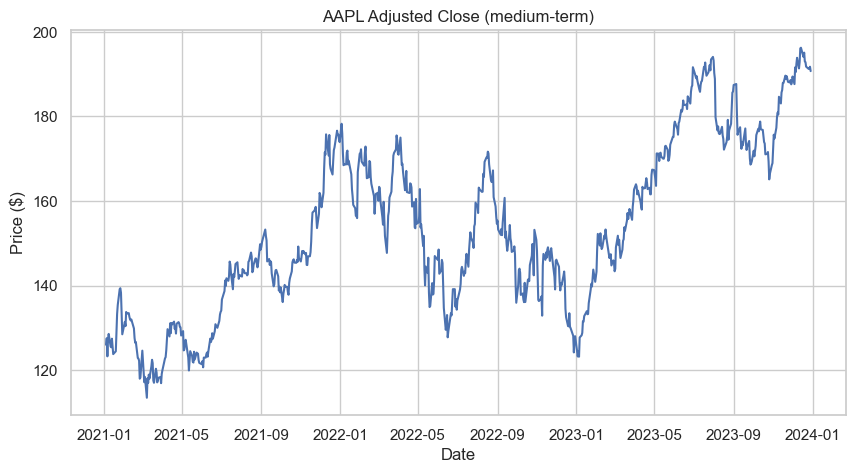

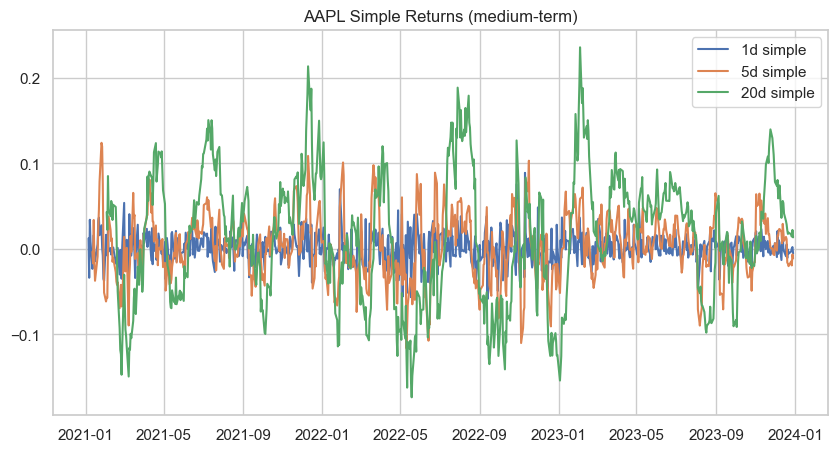

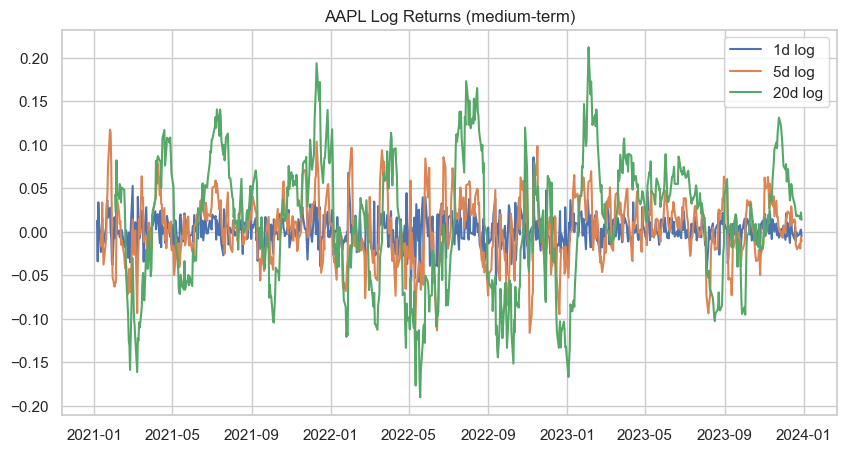

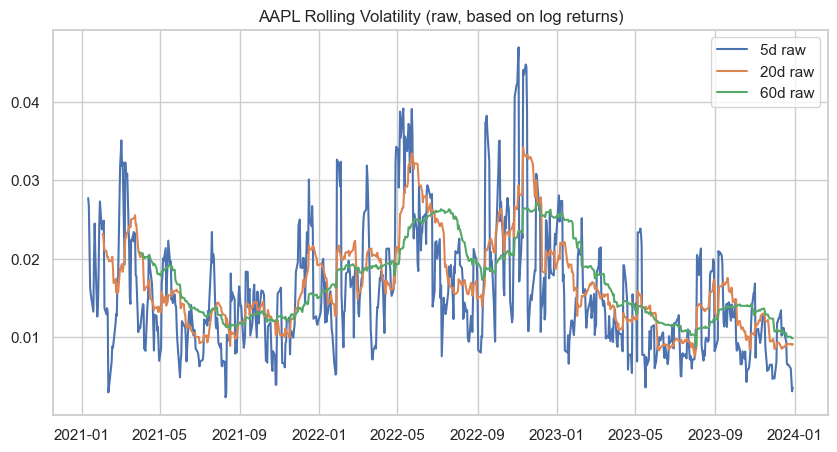

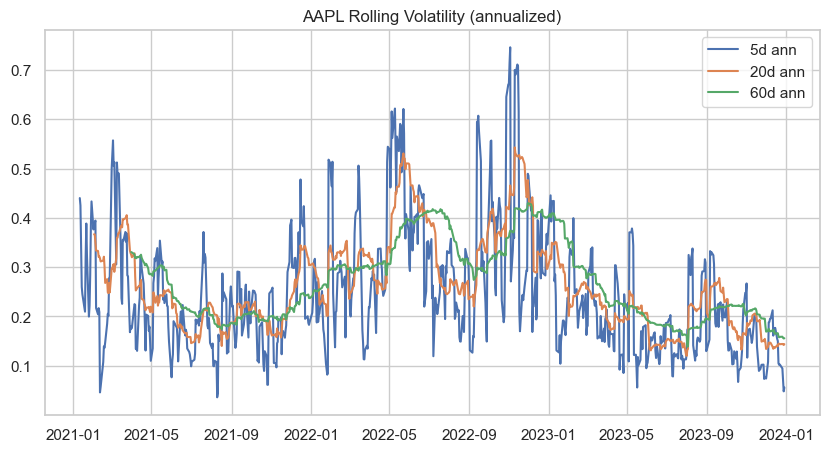

In [12]:
# 7. Plotting - each pointer on a separate graph (as requested)
# 7a. Price
fig, ax = plt.subplots()
ax.plot(price.index, price.values)
ax.set_title(f"{asset} Adjusted Close (medium-term)")
ax.set_ylabel("Price ($)")
ax.set_xlabel("Date")
plt.show()

# 7b. Simple returns (1d, 5d, 20d)
fig, ax = plt.subplots()
ax.plot(med_adj.index, med_adj[f"{asset}_ret_1d_simple"], label="1d simple")
ax.plot(med_adj.index, med_adj[f"{asset}_ret_5d_simple"], label="5d simple")
ax.plot(med_adj.index, med_adj[f"{asset}_ret_20d_simple"], label="20d simple")
ax.set_title(f"{asset} Simple Returns (medium-term)")
ax.legend()
plt.show()

# 7c. Log returns (1d, 5d, 20d)
fig, ax = plt.subplots()
ax.plot(med_adj.index, med_adj[f"{asset}_ret_1d_log"], label="1d log")
ax.plot(med_adj.index, med_adj[f"{asset}_ret_5d_log"], label="5d log")
ax.plot(med_adj.index, med_adj[f"{asset}_ret_20d_log"], label="20d log")
ax.set_title(f"{asset} Log Returns (medium-term)")
ax.legend()
plt.show()

# 7d. Volatility raw (5d, 20d, 60d) - daily std
fig, ax = plt.subplots()
ax.plot(med_adj.index, med_adj[f"{asset}_vol_5d_raw"], label="5d raw")
ax.plot(med_adj.index, med_adj[f"{asset}_vol_20d_raw"], label="20d raw")
ax.plot(med_adj.index, med_adj[f"{asset}_vol_60d_raw"], label="60d raw")
ax.set_title(f"{asset} Rolling Volatility (raw, based on log returns)")
ax.legend()
plt.show()

# 7e. Volatility annualized
fig, ax = plt.subplots()
ax.plot(med_adj.index, med_adj[f"{asset}_vol_5d_ann"], label="5d ann")
ax.plot(med_adj.index, med_adj[f"{asset}_vol_20d_ann"], label="20d ann")
ax.plot(med_adj.index, med_adj[f"{asset}_vol_60d_ann"], label="60d ann")
ax.set_title(f"{asset} Rolling Volatility (annualized)")
ax.legend()
plt.show()

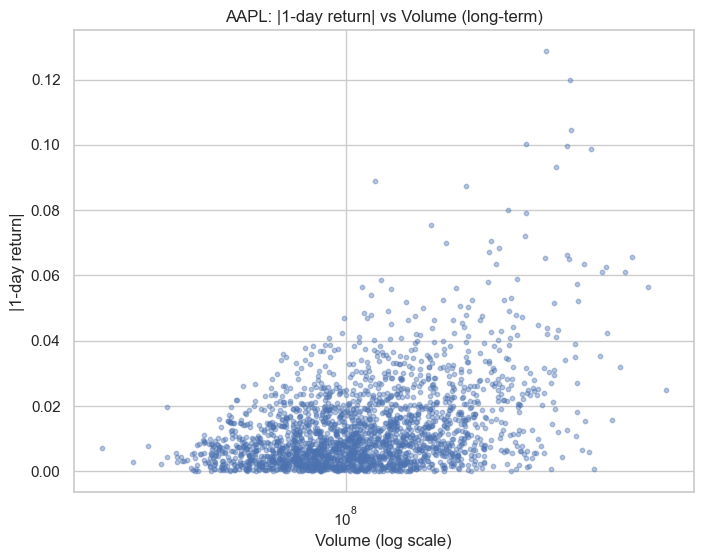

In [13]:
# 8. Bonus: scatter |return| vs Volume (long-term)
# Use 1-day simple returns for the chosen asset over the long term
long_returns_1d = long_adj[asset].pct_change()
long_volume = long_vol[asset].reindex(long_returns_1d.index)

# Drop NaNs for plotting
scatter_df = pd.DataFrame({
    "abs_return": long_returns_1d.abs(),
    "volume": long_volume
}).dropna()

plt.figure(figsize=(8,6))
plt.scatter(scatter_df["volume"], scatter_df["abs_return"], alpha=0.4, s=10)
plt.xscale('log')  # volumes can be skewed; log scale helps
plt.xlabel("Volume (log scale)")
plt.ylabel("|1-day return|")
plt.title(f"{asset}: |1-day return| vs Volume (long-term)")
plt.show()

/var/folders/g0/7bxbysvn2t14r0shxdztp7dm0000gn/T/ipykernel_22835/1530772921.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_mean_ret = long_log_returns.resample('M').mean()
/var/folders/g0/7bxbysvn2t14r0shxdztp7dm0000gn/T/ipykernel_22835/1530772921.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_vol = long_log_returns.resample('M').std() * np.sqrt(252)  # monthly windows annualized for comparability


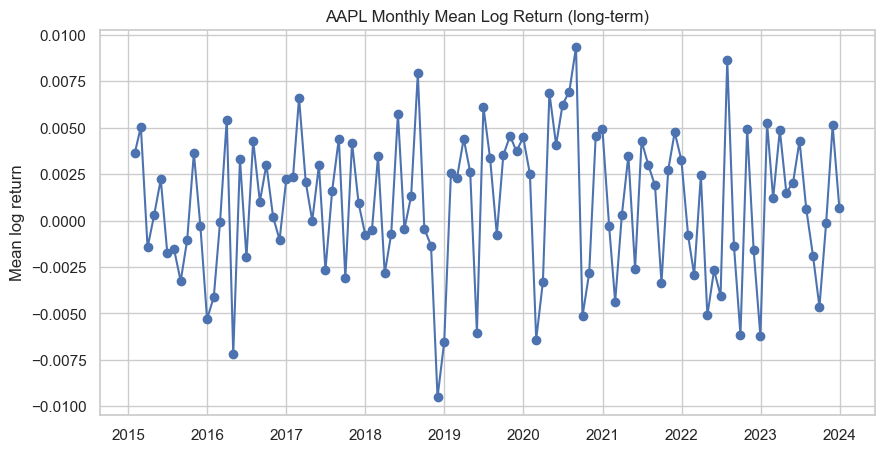

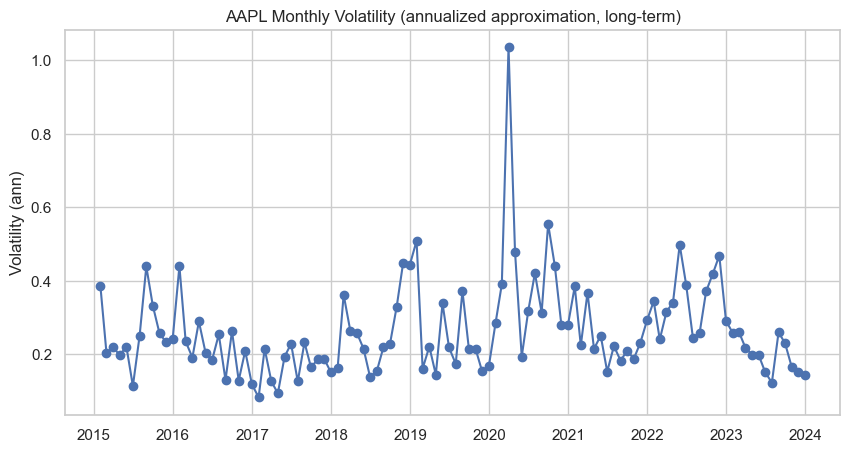


--- Quick analysis template ---
1) Look at price trend: rising/falling/sideways over medium-term?
2) Are 5d/20d returns smoothing the 1d returns as expected?
3) Do vol spikes correspond to known drawdowns or price jumps?
4) In the scatter plot: do larger volumes link to larger |returns|? (outliers matter)
5) Monthly group stats: any seasonal patterns? months with consistently higher volatility?

Fill these with your observations and link to events or earnings releases if you want deeper analysis.


In [14]:
# 9. Bonus: Returns & volatility grouped by month (long-term)
# We'll compute monthly mean returns and monthly volatility (std of daily log returns)
long_log_returns = np.log(long_adj / long_adj.shift(1))
monthly_mean_ret = long_log_returns.resample('M').mean()
monthly_vol = long_log_returns.resample('M').std() * np.sqrt(252)  # monthly windows annualized for comparability

# Plot monthly mean returns for the asset
fig, ax = plt.subplots()
ax.plot(monthly_mean_ret.index, monthly_mean_ret[asset], marker='o')
ax.set_title(f"{asset} Monthly Mean Log Return (long-term)")
ax.set_ylabel("Mean log return")
plt.show()

# Plot monthly volatility
fig, ax = plt.subplots()
ax.plot(monthly_vol.index, monthly_vol[asset], marker='o')
ax.set_title(f"{asset} Monthly Volatility (annualized approximation, long-term)")
ax.set_ylabel("Volatility (ann)")
plt.show()

# 10. Quick analysis notes (fill these in your notebook)
print("\n--- Quick analysis template ---")
print("1) Look at price trend: rising/falling/sideways over medium-term?")
print("2) Are 5d/20d returns smoothing the 1d returns as expected?")
print("3) Do vol spikes correspond to known drawdowns or price jumps?")
print("4) In the scatter plot: do larger volumes link to larger |returns|? (outliers matter)")
print("5) Monthly group stats: any seasonal patterns? months with consistently higher volatility?")
print("\nFill these with your observations and link to events or earnings releases if you want deeper analysis.")

In [15]:
#Task 3
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

asset = "AAPL"   # choose any one ticker

In [16]:
# Log returns
log_ret = np.log(long_adj[asset] / long_adj[asset].shift(1)).dropna()

log_ret.head()
roll_mean_20  = log_ret.rolling(window=20).mean()
roll_mean_60  = log_ret.rolling(window=60).mean()
roll_mean_120 = log_ret.rolling(window=120).mean()

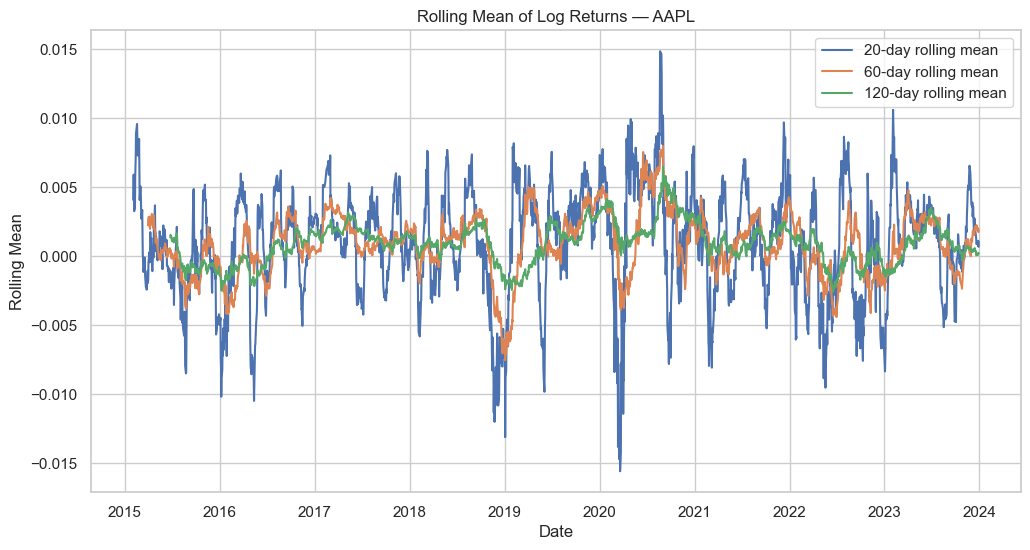

In [17]:
plt.figure(figsize=(12,6))
plt.plot(log_ret.index, roll_mean_20,  label="20-day rolling mean")
plt.plot(log_ret.index, roll_mean_60,  label="60-day rolling mean")
plt.plot(log_ret.index, roll_mean_120, label="120-day rolling mean")

plt.title(f"Rolling Mean of Log Returns — {asset}")
plt.xlabel("Date")
plt.ylabel("Rolling Mean")
plt.legend()
plt.grid(True)
plt.show()

In [18]:
adf_result = adfuller(log_ret)

print("=== ADF Test Result ===")
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
for key, value in adf_result[4].items():
    print(f"Critical Value ({key}): {value}")

=== ADF Test Result ===
ADF Statistic: -14.715253654989068
p-value: 2.8065659924699122e-27
Critical Value (1%): -3.43325450880204
Critical Value (5%): -2.862823135013053
Critical Value (10%): -2.567453072861103


In [19]:
# Task 4 - Volatility Regimes (SMA vs EWMA)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Choose asset and range (we'll use long-term data and zoom to Feb-Mar 2020)
asset = "AAPL"   # change as needed
# if you prefer medium-term, change the source to med_adj
source_df = long_adj  # long_adj expected from earlier cells

In [20]:
# 1) Compute log returns (daily)
log_ret = np.log(source_df[asset] / source_df[asset].shift(1)).dropna()

# 2) Choose zoom window around Feb-Mar 2020 (to highlight COVID crash)
zoom_start = "2020-01-01"
zoom_end   = "2020-06-30"
log_ret_zoom = log_ret.loc[zoom_start:zoom_end]

# 3) Rolling SMA volatility: 20-day rolling std of log returns
window = 20
sma_var = log_ret_zoom.rolling(window=window).var()   # var per day
sma_sigma = np.sqrt(sma_var)

# 4) EWMA (RiskMetrics) with lambda=0.94
lam = 0.94
alpha = 1 - lam  # pandas ewm uses alpha parameter
# compute EWMA variance on squared returns using pandas ewm (adjust=False to match recurrence)
ewma_var = (log_ret_zoom**2).ewm(alpha=alpha, adjust=False).mean()
ewma_sigma = np.sqrt(ewma_var)

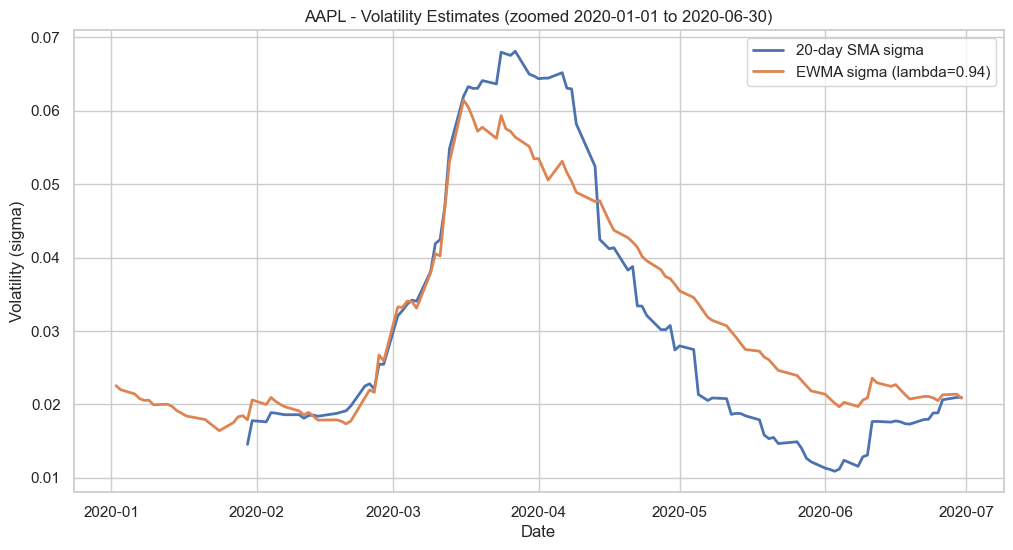

In [21]:
# 5) Plot both on the same chart
plt.figure(figsize=(12,6))
plt.plot(sma_sigma.index, sma_sigma.values, label=f"{window}-day SMA sigma", linewidth=2)
plt.plot(ewma_sigma.index, ewma_sigma.values, label=f"EWMA sigma (lambda={lam})", linewidth=2)
plt.title(f"{asset} - Volatility Estimates (zoomed {zoom_start} to {zoom_end})")
plt.xlabel("Date")
plt.ylabel("Volatility (sigma)")
plt.legend()
plt.grid(True)
plt.show()

60th percentile of EWMA sigma (zoom): 0.030236


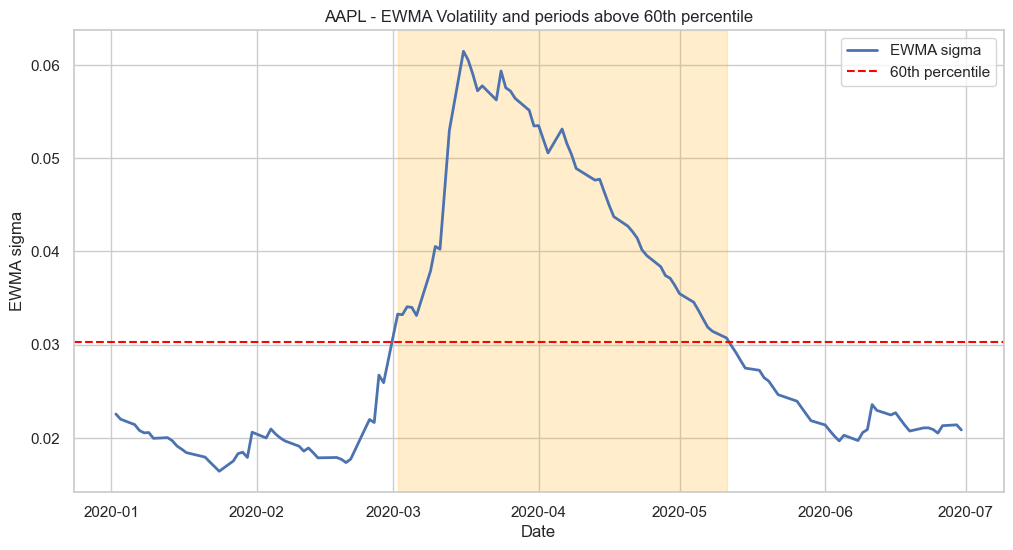

In [23]:
# 6) 60th percentile of EWMA volatility and shading periods where EWMA > threshold
threshold = ewma_sigma.quantile(0.60)
print(f"60th percentile of EWMA sigma (zoom): {threshold:.6f}")

plt.figure(figsize=(12,6))
plt.plot(ewma_sigma.index, ewma_sigma.values, label="EWMA sigma", linewidth=2)
plt.axhline(threshold, color='red', linestyle='--', label="60th percentile")
# shade segments where EWMA > threshold
above = ewma_sigma > threshold
# find contiguous ranges
start = None
for date, cond in above.items():
    if cond and start is None:
        start = date
    if not cond and start is not None:
        plt.axvspan(start, prev_date, color='orange', alpha=0.2)
        start = None
    prev_date = date
# if last segment ends at the end
if start is not None:
    plt.axvspan(start, prev_date, color='orange', alpha=0.2)

plt.title(f"{asset} - EWMA Volatility and periods above 60th percentile")
plt.xlabel("Date")
plt.ylabel("EWMA sigma")
plt.legend()
plt.grid(True)
plt.show()

In [24]:
# 7) Simple smoothness / reaction diagnostics:
#   - Smoothness: compare std of daily changes of each sigma (lower => smoother)
sma_diff_std = (sma_sigma.diff().dropna()).std()
ewma_diff_std = (ewma_sigma.diff().dropna()).std()
print(f"SMA sigma daily-diff std: {sma_diff_std:.6e}")
print(f"EWMA sigma daily-diff std: {ewma_diff_std:.6e}")

#   - Reactivity: compare correlation with absolute returns (abs return should spike with volatility)
corr_sma = sma_sigma.corr(log_ret_zoom.abs())
corr_ewma = ewma_sigma.corr(log_ret_zoom.abs())
print(f"Correlation (SMA sigma, |returns|): {corr_sma:.4f}")
print(f"Correlation (EWMA sigma, |returns|): {corr_ewma:.4f}")

SMA sigma daily-diff std: 2.346526e-03
EWMA sigma daily-diff std: 1.744997e-03
Correlation (SMA sigma, |returns|): 0.4434
Correlation (EWMA sigma, |returns|): 0.4660


In [25]:
# 8) Bonus metric: z_t = r_t / sigma_hat, check Var(z_t) for each estimator
# Align series and drop NaNs
df_diag = pd.DataFrame({
    "r": log_ret_zoom,
    "sma_sigma": sma_sigma,
    "ewma_sigma": ewma_sigma
}).dropna()

df_diag["z_sma"] = df_diag["r"] / df_diag["sma_sigma"]
df_diag["z_ewma"] = df_diag["r"] / df_diag["ewma_sigma"]

var_z_sma = df_diag["z_sma"].var()
var_z_ewma = df_diag["z_ewma"].var()
mean_z_sma = df_diag["z_sma"].mean()
mean_z_ewma = df_diag["z_ewma"].mean()

print("\nBonus metric (should be ~1 for a well-scaled volatility estimator):")
print(f"Var(z) using SMA:  {var_z_sma:.4f}   mean(z): {mean_z_sma:.4e}")
print(f"Var(z) using EWMA: {var_z_ewma:.4f}   mean(z): {mean_z_ewma:.4e}")


Bonus metric (should be ~1 for a well-scaled volatility estimator):
Var(z) using SMA:  1.1618   mean(z): 8.6368e-02
Var(z) using EWMA: 0.9584   mean(z): 3.5708e-02


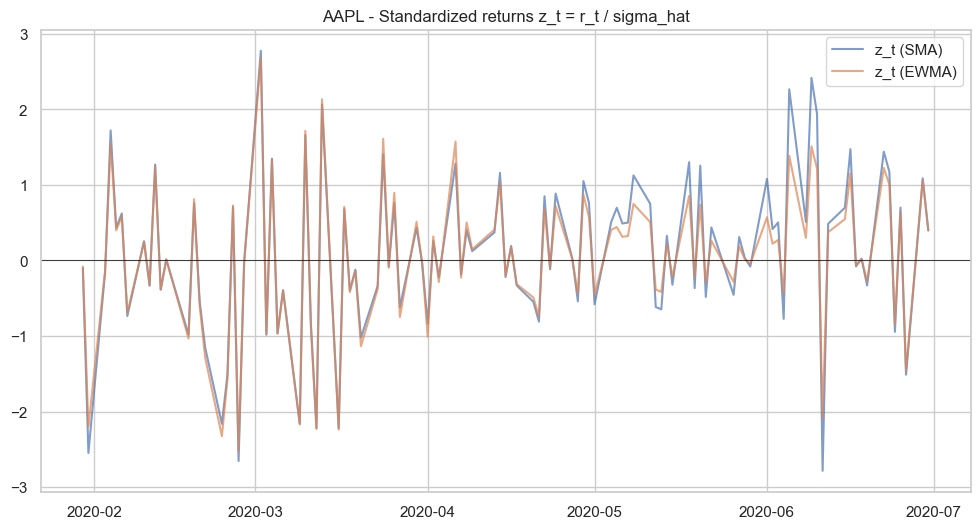

In [26]:
# 9) Quick plots of standardized returns for visual inspection
plt.figure(figsize=(12,6))
plt.plot(df_diag.index, df_diag["z_sma"], label="z_t (SMA)", alpha=0.7)
plt.plot(df_diag.index, df_diag["z_ewma"], label="z_t (EWMA)", alpha=0.7)
plt.axhline(0, color='black', linewidth=0.5)
plt.title(f"{asset} - Standardized returns z_t = r_t / sigma_hat")
plt.legend()
plt.grid(True)
plt.show()

In [36]:
# Task 5
import yfinance as yf
import pandas as pd

# Your birth year
start_date = "2006-01-01"
today = pd.Timestamp.today().strftime("%Y-%m-%d")

# 1. Download NVDA price history (auto-adjusted)
nvda = yf.download("NVDA", start=start_date, end=today)

# 2. Earliest trading day
first_price_date = nvda.index[0]

# Select correct price column
price_col = "Adj Close" if "Adj Close" in nvda.columns else "Close"

# Extract scalar float (not a Series)
first_price = float(nvda[price_col].iloc[0])

print("First trading day:", first_price_date.date())
print("Price on that day:", round(first_price, 4))

# 3. Compute shares
investment = 1000
shares = investment / first_price

print(f"\nIf you invested $1000 in NVDA in {first_price_date.year}:")
print(f"You would have bought {shares:.2f} shares.")

# 4. Latest price
latest_price = float(nvda[price_col].iloc[-1])
current_value = shares * latest_price

print("\nLatest NVDA Price:", round(latest_price, 4))
print(f"Current value of your investment: ${current_value:,.2f}")

# 5. RTX 4090 count
price_4090 = 1600
num_4090s = current_value / price_4090

print(f"\nYou could buy approximately {num_4090s:.1f} RTX 4090 GPUs today.")

/var/folders/g0/7bxbysvn2t14r0shxdztp7dm0000gn/T/ipykernel_22835/1887324326.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  nvda = yf.download("NVDA", start=start_date, end=today)
[*********************100%***********************]  1 of 1 completed

First trading day: 2006-01-03
Price on that day: 0.292

If you invested $1000 in NVDA in 2006:
You would have bought 3424.52 shares.

Latest NVDA Price: 184.97
Current value of your investment: $633,433.38

You could buy approximately 395.9 RTX 4090 GPUs today.



/var/folders/g0/7bxbysvn2t14r0shxdztp7dm0000gn/T/ipykernel_22835/1887324326.py:19: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  first_price = float(nvda[price_col].iloc[0])
/var/folders/g0/7bxbysvn2t14r0shxdztp7dm0000gn/T/ipykernel_22835/1887324326.py:32: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  latest_price = float(nvda[price_col].iloc[-1])
